In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.predict import load_model


from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio, mean_squared_error
import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import yaml
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
def standardize(X: torch.tensor):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

def get_metrics(tomo_path, gt_tomo_path, use_deconv_data):
    
    n2v_psnr, n2v_ssim_idx = None, None
    
    if use_deconv_data=='true':
        use_deconv_data=True
    elif use_deconv_data=='false':
        use_deconv_data=False
    
    if (tomo_path is not None) and (gt_tomo_path is not None):       
        try:
            gt_data = read_array(gt_tomo_path)
            gt_data = torch.tensor(gt_data).unsqueeze(0).unsqueeze(0)
            gt_data = standardize(clip(gt_data))
            
            if use_deconv_data:
                name = tomo_path.split('/')[-1].replace('.mrc', '_deconv_n2vDenoised.mrc')
            else:
                name = tomo_path.split('/')[-1].replace('.mrc', '_n2vDenoised.mrc')
            n2v_pred_path = os.path.join(PARENT_PATH, "data/S2SDenoising/denoised/%s" % (name))
            n2v_data = read_array(n2v_pred_path)
            n2v_data = torch.tensor(n2v_data).unsqueeze(0).unsqueeze(0)
            n2v_data = standardize(clip(n2v_data))
            n2v_psnr, n2v_ssim_idx = float(peak_signal_noise_ratio(n2v_data, gt_data)), float(ssim(n2v_data, gt_data))
            
            
        except OSError:
            pass

        
    return n2v_psnr, n2v_ssim_idx


def logdir_to_dataframe(logdir, ignore_deconv=True):
    data_log = []
    keys = ['Version_comment', 'transform', 'full_tomo_psnr', 'full_tomo_ssim', 'baseline_psnr', 'baseline_ssim',
            'tomo_path', 'gt_tomo_path', 'use_deconv_as_target', 'predict_simRecon', 'use_deconv_data']
    
    all_logs = glob(logdir+'*/*.yaml')
    
    for yaml_logdir in all_logs:
        model = yaml_logdir.split('/')[-3]
        version = yaml_logdir.split('/')[-2]
        with open(yaml_logdir) as f:
            hparams = yaml.load(f, Loader=yaml.BaseLoader)
        
        if 'dataset' in hparams.keys():
            dataset = hparams['dataset']
            
        else:
            # yaml is stupid
            with open(yaml_logdir) as f:
                s = f.readlines()
                try:
                    dataloader = [x for x in s if 'Dataloader' in x][0]
                    dataset = dataloader.split('.')[-1].replace('\n', '').replace('\'', '')
                except:
                    dataset = 'Unknown'

        row_vals = [model, version, dataset, hparams['loss_fn']['alpha']]
        for k in keys:
            try:
                row_vals += [hparams[k]]
            except KeyError:
                row_vals += [None]
        data_log.append(row_vals)

    data_log = pd.DataFrame(data_log, columns=['model', 'version', 'dataset', 'TV_alpha']+keys)
    data_log = data_log.sort_values(['model', 'version'])
    
    if ignore_deconv:
        baseline_metrics = data_log[['tomo_path', 'gt_tomo_path', 'use_deconv_data']].apply(lambda x: get_metrics(x[0], x[1], 'false'), axis=1)
    else:
        baseline_metrics = data_log[['tomo_path', 'gt_tomo_path', 'use_deconv_data']].apply(lambda x: get_metrics(x[0], x[1], x[2]), axis=1)

    data_log['n2v_psnr'], data_log['n2v_ssim'] = zip(*baseline_metrics) 
    data_log[['full_tomo_psnr', 'full_tomo_ssim']] = data_log[['full_tomo_psnr', 'full_tomo_ssim']].astype(float)
    data_log[['baseline_psnr', 'baseline_ssim']] = data_log[['baseline_psnr', 'baseline_ssim']].astype(float)
    
    data_log['baseline_psnr_best'] = data_log.baseline_psnr.max()
    data_log['baseline_ssim_best'] = data_log.baseline_ssim.max()

    tomo_path = data_log.tomo_path.map(lambda x: x.split('/')[-1] if x is not None else x)
    gt_tomo_path = data_log.gt_tomo_path.map(lambda x: x.split('/')[-1] if x is not None else x)

    # data_log.drop(['tomo_path', 'gt_tomo_path'], axis=1, inplace=True)
    data_log['tomo_path'], data_log['gt_tomo_path'] = [tomo_path, gt_tomo_path]
    
    _vals = 100*data_log[['full_tomo_ssim', 'n2v_ssim']].apply(lambda x: (x-data_log['baseline_ssim_best'])/data_log['baseline_ssim_best'])
    data_log['ssim_vs_baseline'], data_log['n2v_ssim_vs_baseline'] = zip(*_vals.values)

    _vals = 100*data_log[['full_tomo_psnr', 'n2v_psnr']].apply(lambda x: (x-data_log['baseline_psnr_best'])/data_log['baseline_psnr_best'])
    data_log['psnr_vs_baseline'], data_log['n2v_psnr_vs_baseline'] = zip(*_vals.values)
    
    return data_log

# Model 14

## normal_vs_deconvolved

**Conclusions about this experiments**

1. N2V is significantly better at dealing with pixel independent noise like Poisson and Gaussian. Second best is dropout method.
2. When adding structured noise to the mix, N2V's performance heavily drops. Best model is Fourier samples.
3. It seems that deconvolution is not helping in any way for denoising in this case.

### Gauss + Poiss

In [46]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomoPhantom_model14_noisyGaussPoiss/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},11.9558,0.9020,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,true,27.9010,0.9989,12.8885,0.9598,-6.0215,4.0742,-7.2365,116.4799
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},18.0498,0.9771,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.9010,0.9989,12.8885,0.9598,1.7970,4.0742,40.0453,116.4799
8,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},13.1768,0.9234,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,true,27.9010,0.9989,12.8885,0.9598,-3.7946,4.0742,2.2366,116.4799
6,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},16.1784,0.9723,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.9010,0.9989,12.8885,0.9598,1.2963,4.0742,25.5258,116.4799
5,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},12.0031,0.9112,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,true,true,true,27.9010,0.9989,12.8885,0.9598,-5.0700,4.0742,-6.8698,116.4799
7,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},16.8991,0.9421,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,false,true,true,27.9010,0.9989,12.8885,0.9598,-1.8429,4.0742,31.1172,116.4799
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},12.2984,0.9070,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,true,false,true,27.9010,0.9989,12.8885,0.9598,-5.5062,4.0742,-4.5784,116.4799
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},17.6600,0.9751,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,false,false,true,27.9010,0.9989,12.8885,0.9598,1.5951,4.0742,37.0215,116.4799
4,normal_vs_deconvolved_comparison,version_8,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},12.2741,0.9067,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,true,false,true,27.9010,0.9989,12.8885,0.9598,-5.5365,4.0742,-4.7668,116.4799


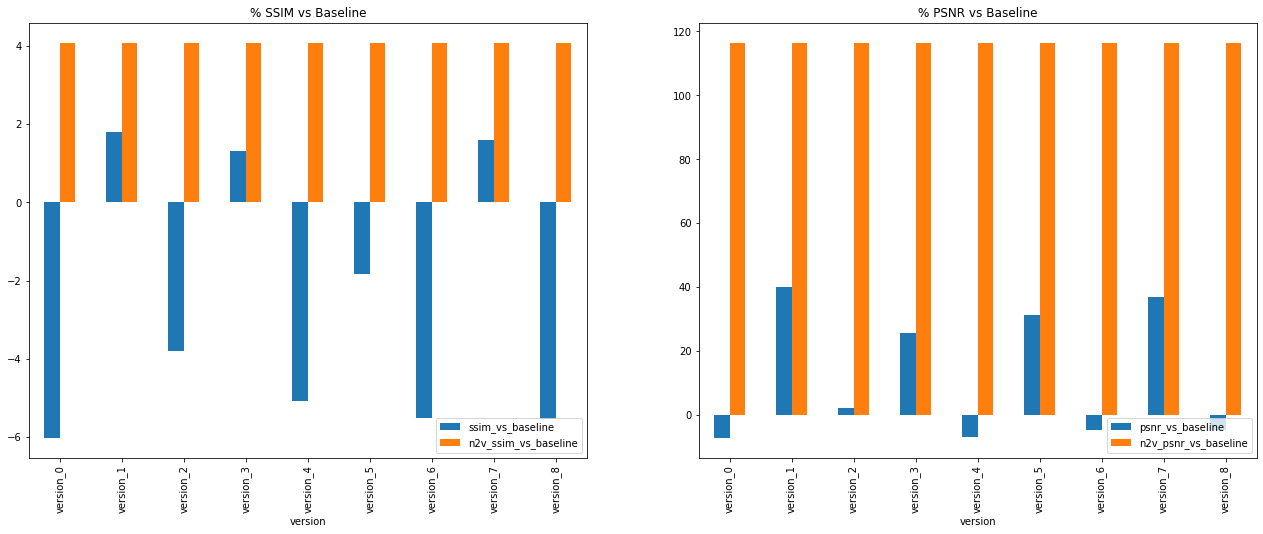

In [47]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

### Gauss + Poiss + Perlin

In [40]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomoPhantom_model14_noisyGaussPoissPerlin/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},11.8060,0.8935,11.7780,0.8942,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,true,16.9207,0.9507,12.7716,0.9479,-5.7413,0.2913,-7.5602,32.4867
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},16.9301,0.9635,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.9207,0.9507,12.7716,0.9479,1.6494,0.2913,32.5607,32.4867
8,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},12.9671,0.9154,11.7780,0.8942,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,true,16.9207,0.9507,12.7716,0.9479,-3.4271,0.2913,1.5308,32.4867
6,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},15.9272,0.9657,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.9207,0.9507,12.7716,0.9479,1.8787,0.2913,24.7079,32.4867
5,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},11.9105,0.9038,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,true,true,true,16.9207,0.9507,12.7716,0.9479,-4.6529,0.2913,-6.7423,32.4867
7,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},16.5386,0.9410,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,false,true,true,16.9207,0.9507,12.7716,0.9479,-0.7222,0.2913,29.4953,32.4867
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},12.2595,0.9003,11.7780,0.8942,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,true,false,true,16.9207,0.9507,12.7716,0.9479,-5.0239,0.2913,-4.0098,32.4867
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},16.8452,0.9640,12.7716,0.9479,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,false,false,true,16.9207,0.9507,12.7716,0.9479,1.6940,0.2913,31.8960,32.4867
4,normal_vs_deconvolved_comparison,version_8,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},12.2367,0.8999,11.7780,0.8942,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,true,false,true,16.9207,0.9507,12.7716,0.9479,-5.0682,0.2913,-4.1879,32.4867


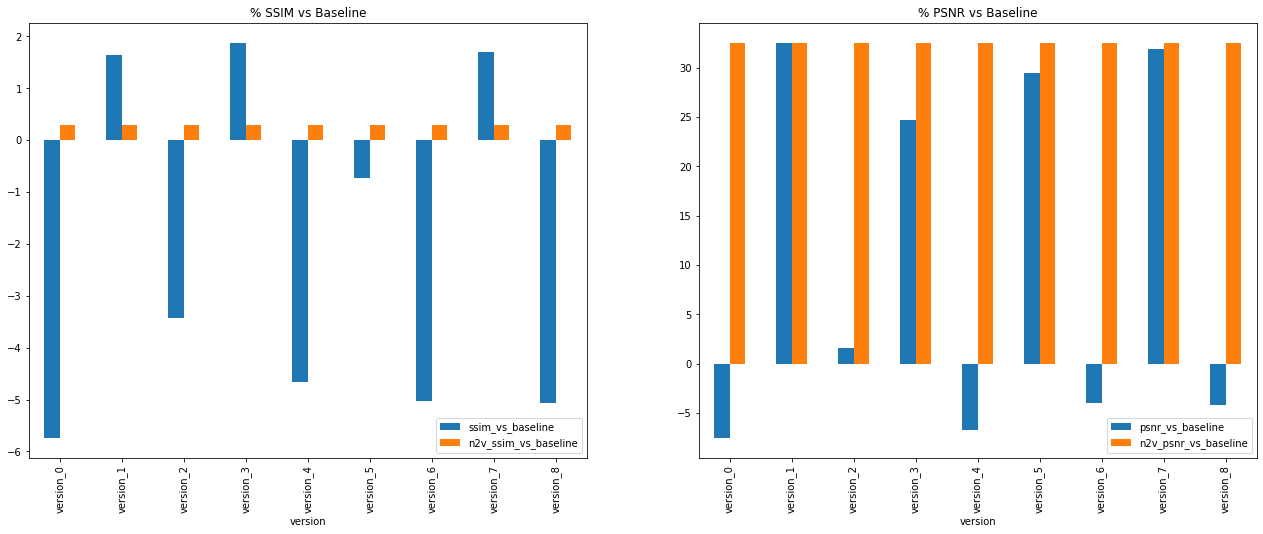

In [41]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

## Fourier sampling

**Conclusions about this experiments**

1. Not necessary to be comparing deconvolved fo the tomoPhantom models
2. Noisy input as target has poor performance

### Gauss + Poiss

In [11]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomoPhantom_model14_noisyGaussPoiss/fourierSampling_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,fourierSampling_comparison,version_0,singleCET_FourierDataset,0,Deconvolved Fourier with hiFreqMask,{'p': '0.5'},12.5813,0.9108,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,true,27.9010,0.9989,12.8885,0.9598,-5.1116,4.0742,-2.3835,116.4799
1,fourierSampling_comparison,version_1,singleCET_FourierDataset,0,Fourier with hiFreqMask,{'p': '0.5'},17.8022,0.9756,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.9010,0.9989,12.8885,0.9598,1.6453,4.0742,38.1243,116.4799
5,fourierSampling_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier no hiFreqMask,{'p': '0.5'},13.1820,0.9235,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,true,27.9010,0.9989,12.8885,0.9598,-3.7808,4.0742,2.2770,116.4799
3,fourierSampling_comparison,version_3,singleCET_FourierDataset,0,Fourier no hiFreqMask (OG),{'p': '0.5'},16.1378,0.9721,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.9010,0.9989,12.8885,0.9598,1.2783,4.0742,25.2107,116.4799
2,fourierSampling_comparison,version_4,singleCET_FourierDataset,0,Deconvolved Fourier mix hiFreqMask with p=0.5,{'p': '0.5'},12.9998,0.9193,11.9046,0.9025,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,true,27.9010,0.9989,12.8885,0.9598,-4.2215,4.0742,0.8631,116.4799
4,fourierSampling_comparison,version_5,singleCET_FourierDataset,0,Fourier mix hiFreqMask with p=0.5,{'p': '0.5'},17.7327,0.9755,12.8885,0.9598,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.9010,0.9989,12.8885,0.9598,1.6312,4.0742,37.5855,116.4799


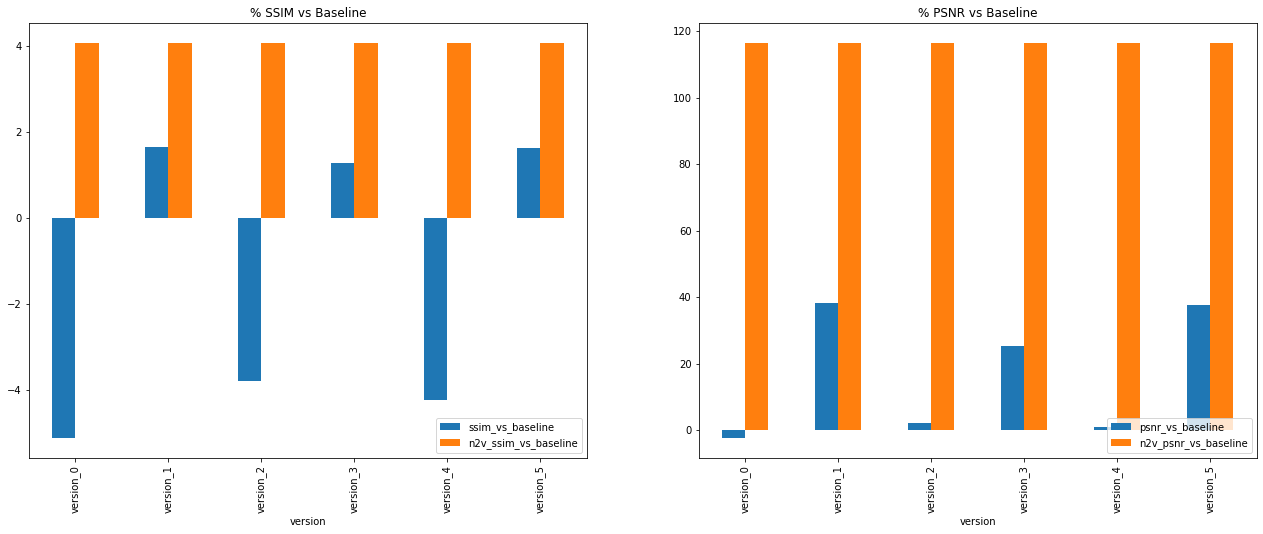

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

### Gauss + Poiss + Perlin

In [25]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomoPhantom_model14_noisyGaussPoissPerlin/fourierSampling_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,fourierSampling_comparison,version_0,singleCET_FourierDataset,0,Deconvolved Fourier with hiFreqMask,{'p': '0.5'},12.319558,0.900798,11.777988,0.894208,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,true,16.920658,0.950655,12.771588,0.947894,-4.968546,0.291253,-3.539342,32.486717
1,fourierSampling_comparison,version_1,singleCET_FourierDataset,0,Fourier with hiFreqMask,{'p': '0.5'},16.723494,0.961838,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.471054,0.291253,30.942943,32.486717
5,fourierSampling_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier no hiFreqMask,{'p': '0.5'},12.930706,0.914787,11.777988,0.894208,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,true,16.920658,0.950655,12.771588,0.947894,-3.492719,0.291253,1.245872,32.486717
3,fourierSampling_comparison,version_3,singleCET_FourierDataset,0,Fourier no hiFreqMask (OG),{'p': '0.5'},15.949806,0.965829,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.892087,0.291253,24.885064,32.486717
2,fourierSampling_comparison,version_4,singleCET_FourierDataset,0,Deconvolved Fourier mix hiFreqMask with p=0.5,{'p': '0.5'},12.831903,0.912914,11.777988,0.894208,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,true,16.920658,0.950655,12.771588,0.947894,-3.690336,0.291253,0.472253,32.486717
4,fourierSampling_comparison,version_5,singleCET_FourierDataset,0,Fourier mix hiFreqMask with p=0.5,{'p': '0.5'},16.594761,0.962868,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.579737,0.291253,29.934981,32.486717


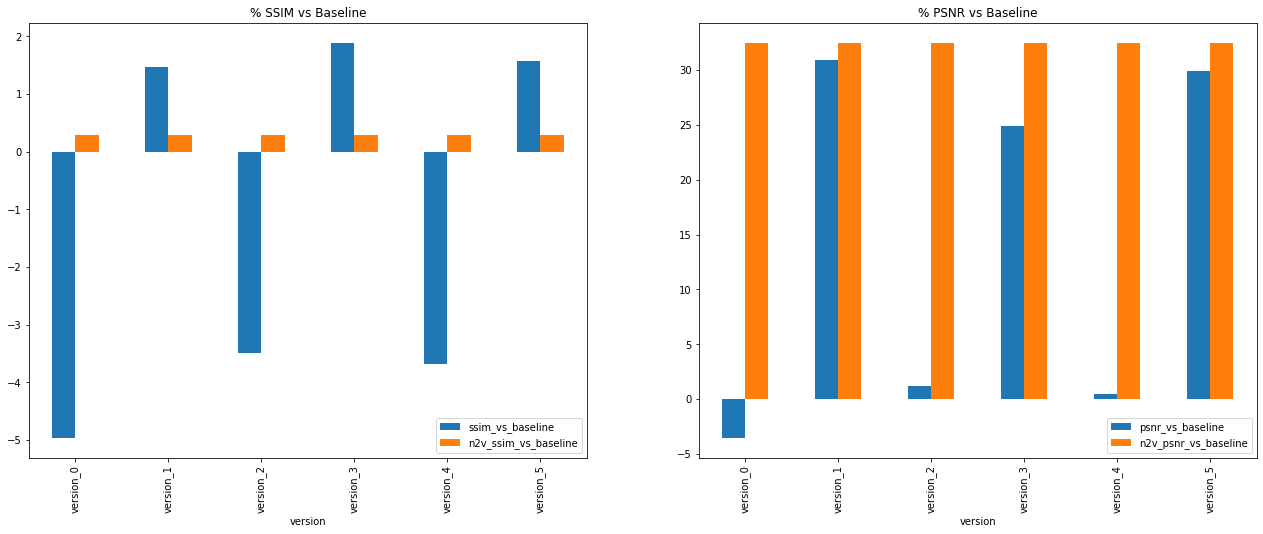

In [26]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

## Fourier Target

**Conclusions about this experiments**

1. High frequency masking seems to already achieve some good denoising for non structured noise

### Gauss + Poiss

In [27]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomoPhantom_model14_noisyGaussPoiss/fourierTarget_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,fourierTarget_comparison,version_0,singleCET_FourierDataset,0,"Fourier with hiFreqMask, input as target",{'p': '0.5'},17.401529,0.974485,12.888515,0.959836,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.901043,0.998942,12.888515,0.959836,1.526233,4.074196,35.015787,116.479897
1,fourierTarget_comparison,version_1,singleCET_FourierDataset,0,Fourier with hiFreqMask,{'p': '0.5'},17.805651,0.975634,12.888515,0.959836,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.901043,0.998942,12.888515,0.959836,1.645891,4.074196,38.151303,116.479897
5,fourierTarget_comparison,version_2,singleCET_FourierDataset,0,Fourier hiFreqMask_prob=0.5 input as target,{'p': '0.5'},17.053740,0.973780,12.888515,0.959836,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.901043,0.998942,12.888515,0.959836,1.452745,4.074196,32.317340,116.479897
3,fourierTarget_comparison,version_3,singleCET_FourierDataset,0,Fourier hiFreqMask_prob=0.5,{'p': '0.5'},17.553349,0.974362,12.888515,0.959836,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.901043,0.998942,12.888515,0.959836,1.513385,4.074196,36.193729,116.479897
2,fourierTarget_comparison,version_4,singleCET_FourierDataset,0,"Fourier no hiFreqMask, input as target",{'p': '0.5'},16.134741,0.972323,12.888515,0.959836,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.901043,0.998942,12.888515,0.959836,1.300926,4.074196,25.186970,116.479897
4,fourierTarget_comparison,version_5,singleCET_FourierDataset,0,Fourier no hiFreqMask,{'p': '0.5'},16.146269,0.971229,12.888515,0.959836,tomoPhantom_model14_noisyGaussPoiss.mrc,tomoPhantom_model14.mrc,null,null,false,27.901043,0.998942,12.888515,0.959836,1.186975,4.074196,25.276414,116.479897


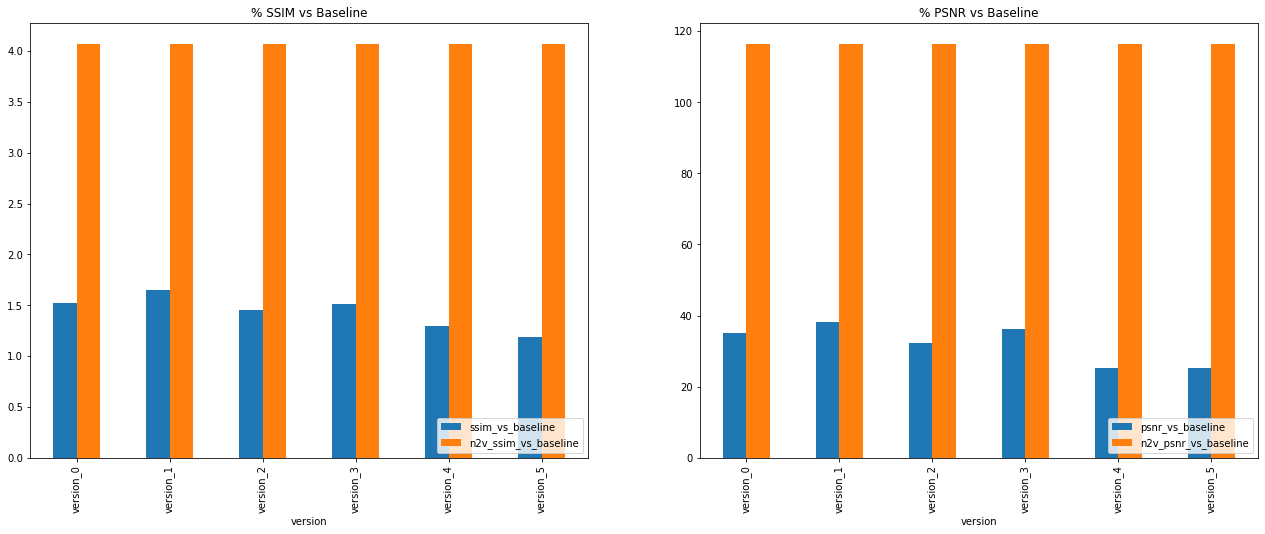

In [28]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

### Gauss + Poiss + Perlin

In [22]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomoPhantom_model14_noisyGaussPoissPerlin/fourierTarget_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,fourierTarget_comparison,version_0,singleCET_FourierDataset,0,"Fourier with hiFreqMask, input as target",{'p': '0.5'},16.501024,0.961307,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.415033,0.291253,29.201035,32.486717
1,fourierTarget_comparison,version_1,singleCET_FourierDataset,0,Fourier with hiFreqMask,{'p': '0.5'},16.743650,0.962032,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.491547,0.291253,31.100768,32.486717
5,fourierTarget_comparison,version_2,singleCET_FourierDataset,0,Fourier hiFreqMask_prob=0.5 input as target,{'p': '0.5'},16.297897,0.962200,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.509279,0.291253,27.610575,32.486717
3,fourierTarget_comparison,version_3,singleCET_FourierDataset,0,Fourier hiFreqMask_prob=0.5,{'p': '0.5'},16.685076,0.963748,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.672531,0.291253,30.642136,32.486717
2,fourierTarget_comparison,version_4,singleCET_FourierDataset,0,"Fourier no hiFreqMask, input as target",{'p': '0.5'},15.615211,0.961562,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.441946,0.291253,22.265220,32.486717
4,fourierTarget_comparison,version_5,singleCET_FourierDataset,0,Fourier no hiFreqMask,{'p': '0.5'},15.770843,0.963670,12.771588,0.947894,tomoPhantom_model14_noisyGaussPoissPerlin.mrc,tomoPhantom_model14.mrc,null,null,false,16.920658,0.950655,12.771588,0.947894,1.664268,0.291253,23.483800,32.486717


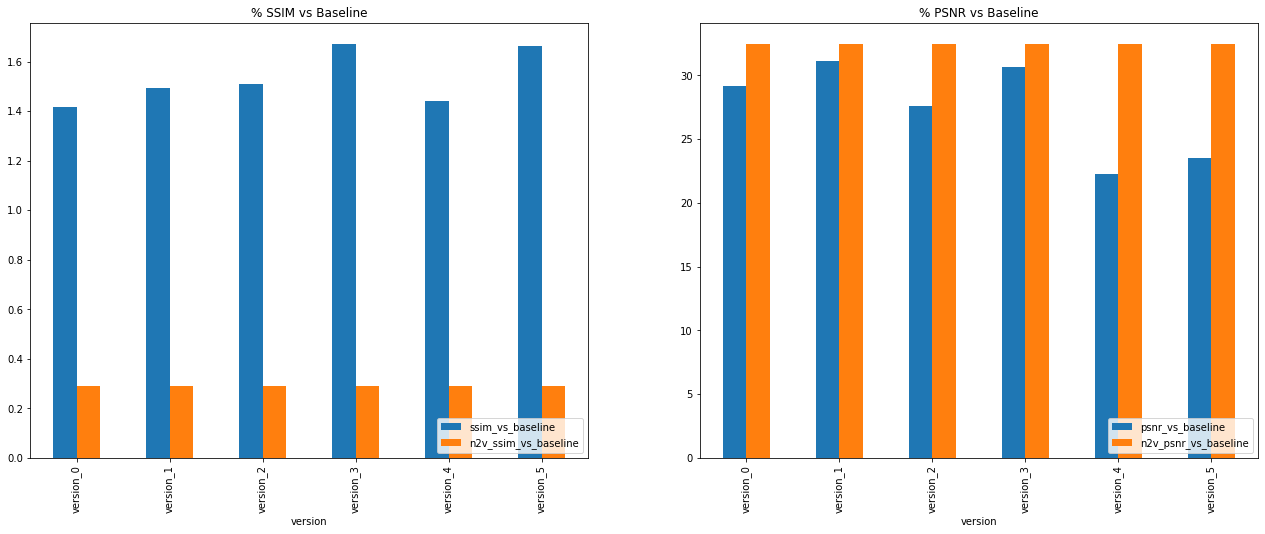

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

# Shrec2021

**Normal vs deconvolved**

1. Deconvolving data does not seem to be yielding better results in this case. Keep in mind that here the ground truth is the simulated proteins in perfect imaging conditions, not cryoCARE.
2. 

## Normal vs deconvolved

In [3]:
logdir = 'data/S2SDenoising/tryout_model_logs/shrec2021_model4_dummy/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},10.140672,0.866918,10.126170,0.867574,shrec2021_model4_dummy.mrc,shrec2021_model4_gtDummy.mrc,null,null,true,NaN,NaN,10.974474,0.904320,-4.135917,NaN,-7.597651,NaN
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},11.828440,0.911511,10.974474,0.904320,shrec2021_model4_dummy.mrc,shrec2021_model4_gtDummy.mrc,null,null,false,10.958924,0.904241,10.974474,0.904320,0.795236,-0.008760,7.781382,-0.141689
6,normal_vs_deconvolved_comparison,version_2,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},10.263887,0.869246,10.126170,0.867574,shrec2021_model4_dummy.mrc,shrec2021_model4_gtDummy.mrc,true,false,true,NaN,NaN,10.974474,0.904320,-3.878429,NaN,-6.474903,NaN
4,normal_vs_deconvolved_comparison,version_3,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},11.903604,0.911544,10.974474,0.904320,shrec2021_model4_dummy.mrc,shrec2021_model4_gtDummy.mrc,false,false,true,NaN,NaN,10.974474,0.904320,0.798881,NaN,8.466279,NaN
3,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},10.259636,0.869209,10.126170,0.867574,shrec2021_model4_dummy.mrc,shrec2021_model4_gtDummy.mrc,true,false,true,NaN,NaN,10.974474,0.904320,-3.882595,NaN,-6.513643,NaN
5,normal_vs_deconvolved_comparison,version_5,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},10.955809,0.886170,10.126170,0.867574,shrec2021_model4_dummy.mrc,shrec2021_model4_gtDummy.mrc,null,null,true,NaN,NaN,10.974474,0.904320,-2.006984,NaN,-0.170079,NaN
0,normal_vs_deconvolved_comparison,version_6,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},12.272408,0.915737,10.974474,0.904320,shrec2021_model4_dummy.mrc,shrec2021_model4_gtDummy.mrc,null,null,false,10.958924,0.904241,10.974474,0.904320,1.262513,-0.008760,11.826850,-0.141689


In [4]:
data_log.set_index(['version', 'Version_comment'])[['dataset', 'full_tomo_psnr', 'full_tomo_ssim', 'baseline_psnr_best', 'baseline_ssim_best']]

,,dataset,full_tomo_psnr,full_tomo_ssim,baseline_psnr_best,baseline_ssim_best
version,Version_comment,,,,,
version_0,Deconvolved bernoulli,singleCET_dataset,10.140672,0.866918,10.974474,0.904320
version_1,Bernoull,singleCET_dataset,11.828440,0.911511,10.974474,0.904320
version_2,Sim N2N denoising using deconv data as target.,singleCET_ProjectedDataset,10.263887,0.869246,10.974474,0.904320
version_3,Sim N2N denoising using raw data as target.,singleCET_ProjectedDataset,11.903604,0.911544,10.974474,0.904320
version_4,Sim N2N denoising using deconvolved data as target.,singleCET_ProjectedDataset,10.259636,0.869209,10.974474,0.904320
version_5,Deconvolved Fourier,singleCET_FourierDataset,10.955809,0.886170,10.974474,0.904320
version_6,Fourier,singleCET_FourierDataset,12.272408,0.915737,10.974474,0.904320


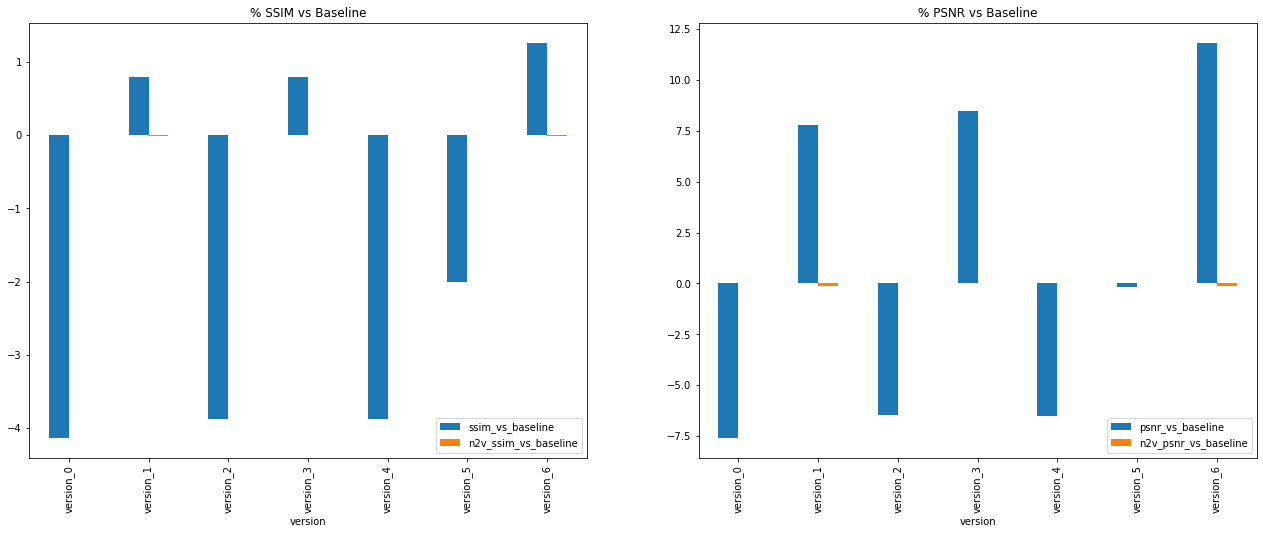

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

## Dataset comparison

### Gaussian + Poisson

In [6]:
logdir = 'data/S2SDenoising/tryout_model_logs/shrec2021_model4_dummy_noisyGaussPoiss/dataset_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,dataset_comparison,version_0,singleCET_dataset,0,Bernoull,{'p': '0.5'},14.183035,0.933683,11.372500,0.913189,shrec2021_model4_dummy_noisyGaussPoiss.mrc,shrec2021_model4_gtDummy.mrc,null,null,false,11.195571,0.908885,11.372500,0.913189,2.244254,-0.471354,24.713426,-1.555766
1,dataset_comparison,version_1,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},13.133212,0.927238,11.372500,0.913189,shrec2021_model4_dummy_noisyGaussPoiss.mrc,shrec2021_model4_gtDummy.mrc,null,null,false,11.195571,0.908885,11.372500,0.913189,1.538506,-0.471354,15.482186,-1.555766
2,dataset_comparison,version_2,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},13.367379,0.927095,11.372500,0.913189,shrec2021_model4_dummy_noisyGaussPoiss.mrc,shrec2021_model4_gtDummy.mrc,false,false,true,NaN,NaN,11.372500,0.913189,1.522796,NaN,17.541250,NaN


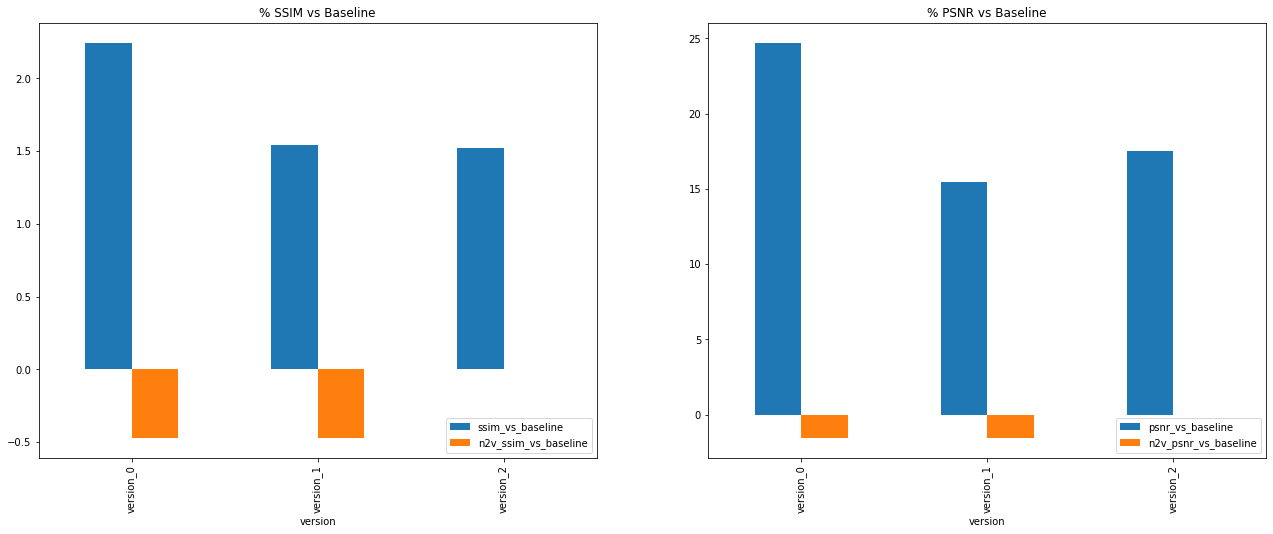

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

### Gaussian + Poisson + Perlin

In [15]:
logdir = 'data/S2SDenoising/tryout_model_logs/shrec2021_model4_dummy_noisyGaussPoissPerlin/dataset_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

ValueError: too many values to unpack (expected 2)

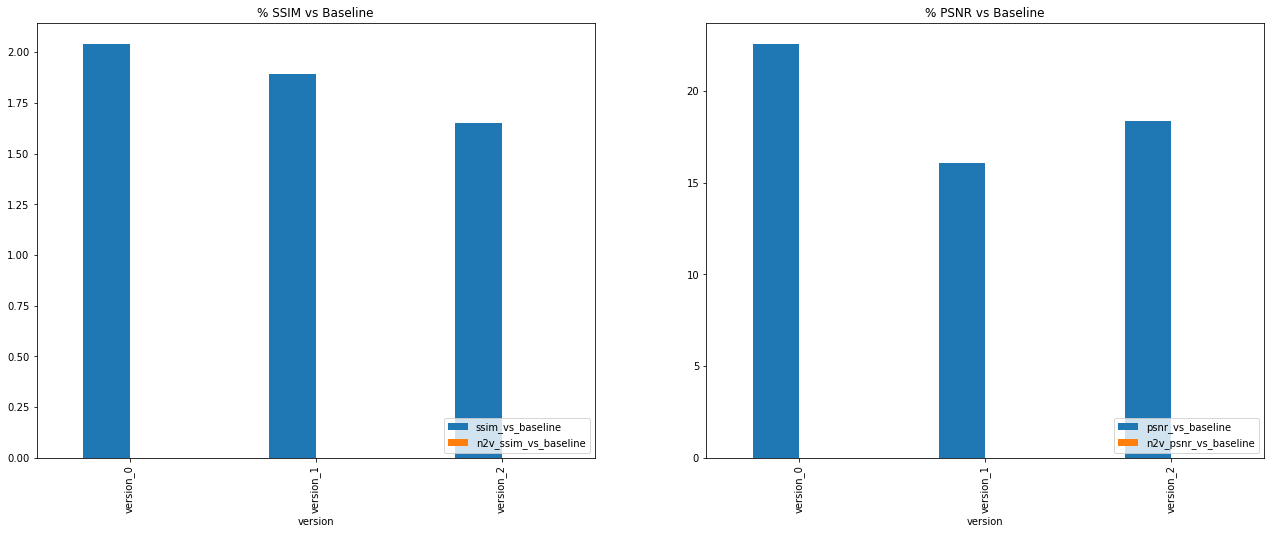

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

### Gaussian + Poisson + Perlin High Freq

In [13]:
logdir = 'data/S2SDenoising/tryout_model_logs/shrec2021_model4_dummy_noisyGaussPoissPerlinHighFreq/dataset_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,dataset_comparison,version_0,singleCET_dataset,0,Bernoull,{'p': '0.5'},13.955667,0.925506,11.383606,0.906983,shrec2021_model4_dummy_noisyGaussPoissPerlinHi...,shrec2021_model4_gtDummy.mrc,null,null,false,None,None,11.383606,0.906983,2.042250,NaN,22.594436,NaN
1,dataset_comparison,version_1,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},13.211265,0.924132,11.383606,0.906983,shrec2021_model4_dummy_noisyGaussPoissPerlinHi...,shrec2021_model4_gtDummy.mrc,null,null,false,None,None,11.383606,0.906983,1.890725,NaN,16.055182,NaN
2,dataset_comparison,version_2,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},13.475984,0.921948,11.383606,0.906983,shrec2021_model4_dummy_noisyGaussPoissPerlinHi...,shrec2021_model4_gtDummy.mrc,false,false,true,None,None,11.383606,0.906983,1.649982,NaN,18.380623,NaN


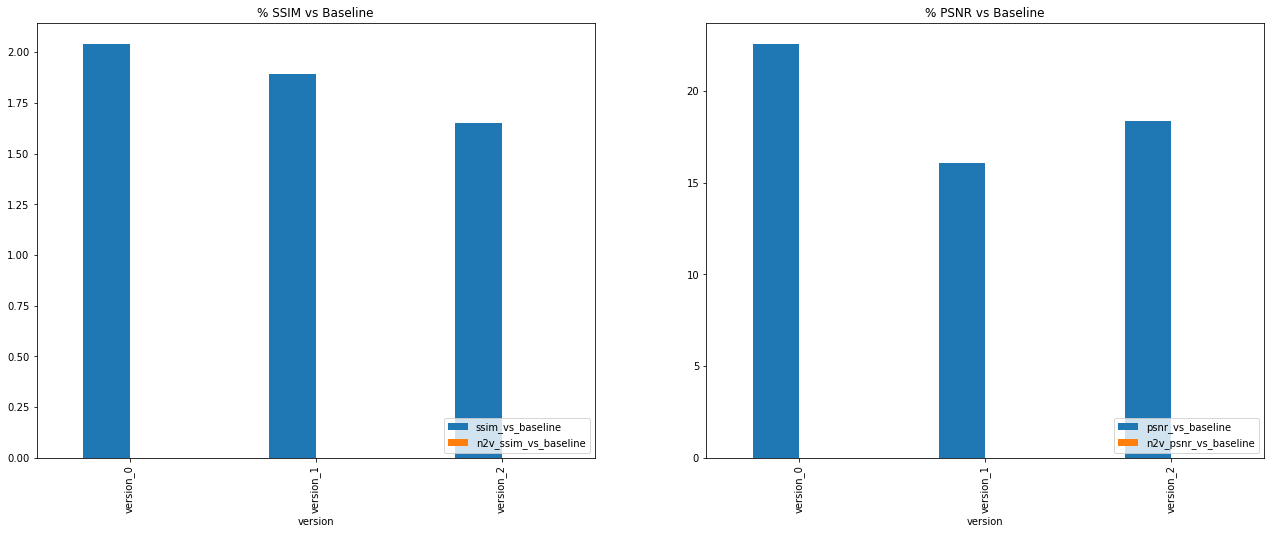

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

# Tomo02 Dummy

**Conclusions about this experiments**

1. It seems that Fourier sampling is the one with best denoising capabilities. In particular, for this tomogram, it seems that first deconvolving and then denoising using Fourier sampling seems to be the most effective.
2. Sim N2N using reconstruction as target in both normal and deconvolved cases does not seem to work as expected.
3. Raw data as target for the Projected Dataset seems to be working good in the Gauss+Poiss case, but not on any other cases

## normal vs deconvolved

In [13]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo02_dummy/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},17.505190,0.977715,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,None,true,16.253181,0.976708,17.703468,0.978664,-0.096953,-0.199851,-1.119998,-8.192106
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},16.548168,0.967042,14.609753,0.964178,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,None,false,14.607004,0.964603,17.703468,0.978664,-1.187575,-1.436703,-6.525841,-17.490720
7,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},18.639153,0.986368,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,None,true,16.253181,0.976708,17.703468,0.978664,0.787161,-0.199851,5.285316,-8.192106
5,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},16.148682,0.969076,14.609753,0.964178,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,None,false,14.607004,0.964603,17.703468,0.978664,-0.979746,-1.436703,-8.782385,-17.490720
4,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},16.405691,0.964704,14.609753,0.964178,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,true,true,true,16.253181,0.976708,17.703468,0.978664,-1.426435,-0.199851,-7.330638,-8.192106
6,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},16.700397,0.960784,14.609753,0.964178,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,false,true,true,16.253181,0.976708,17.703468,0.978664,-1.827013,-0.199851,-5.665957,-8.192106
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},17.172709,0.972785,14.609753,0.964178,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,false,false,true,16.253181,0.976708,17.703468,0.978664,-0.600685,-0.199851,-2.998056,-8.192106
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},17.318031,0.978116,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,16.253181,0.976708,17.703468,0.978664,-0.055965,-0.199851,-2.177184,-8.192106


In [27]:
data_log.set_index(['version', 'Version_comment'])[['dataset', 'full_tomo_psnr', 'full_tomo_ssim', 'baseline_psnr_best', 'baseline_ssim_best']]

,,dataset,full_tomo_psnr,full_tomo_ssim,baseline_psnr_best,baseline_ssim_best
version,Version_comment,,,,,
version_0,Deconvolved bernoulli,singleCET_dataset,17.505190,0.977715,17.703468,0.978664
version_1,Bernoull,singleCET_dataset,16.548168,0.967042,17.703468,0.978664
version_2,Deconvolved Fourier,singleCET_FourierDataset,18.639153,0.986368,17.703468,0.978664
version_3,Fourier,singleCET_FourierDataset,16.148682,0.969076,17.703468,0.978664
version_4,Sim N2N denoising using deconv reconstruction as target.,singleCET_ProjectedDataset,16.405691,0.964704,17.703468,0.978664
version_5,Sim N2N denoising using reconstruction as target.,singleCET_ProjectedDataset,16.700397,0.960784,17.703468,0.978664
version_6,Sim N2N denoising using raw data as target.,singleCET_ProjectedDataset,17.172709,0.972785,17.703468,0.978664
version_7,Sim N2N denoising using deconvolved data as target.,singleCET_ProjectedDataset,17.318031,0.978116,17.703468,0.978664


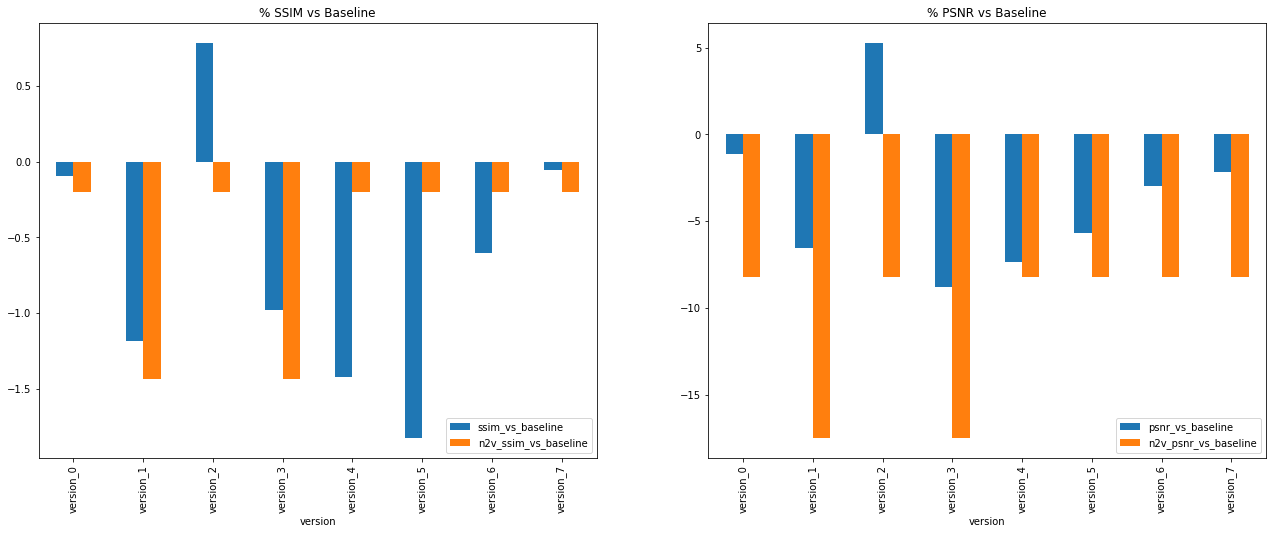

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

### Best model

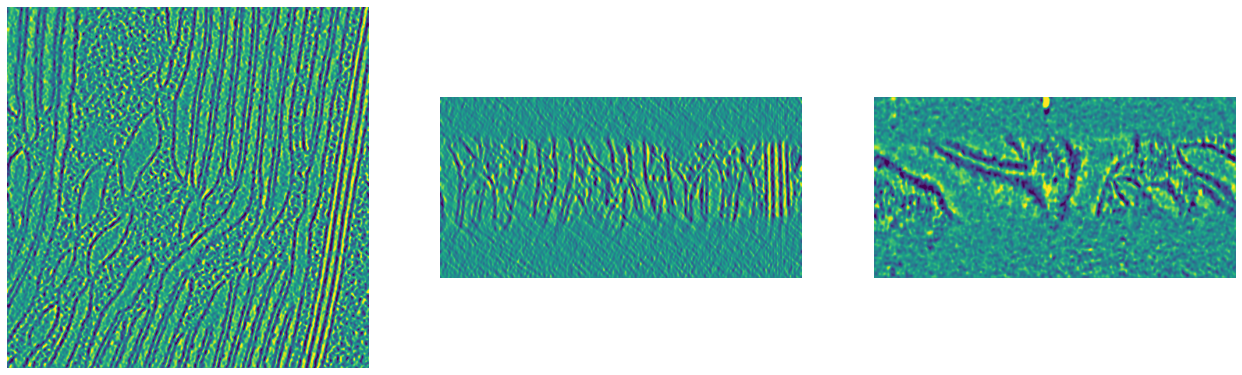

In [26]:
best_version = data_log[data_log.psnr_vs_baseline==data_log.psnr_vs_baseline.max()].version.values[0]
best = read_array(logdir+'%s/tomo02_dummy_s2sDenoised.mrc' %best_version)
best = standardize(clip(best))


fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(22, 12))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1, ax2]).ravel()))
zidx, yidx, xidx = np.array(best.shape)//2

ax0.imshow(best[zidx])
ax1.imshow(best[:, yidx, :])
ax2.imshow(best[:, :, xidx])

## High Freq Fourier Mask comparison

In [10]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo02_dummy/fourierHighFreqMask_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,fourierHighFreqMask_comparison,version_0,singleCET_FourierDataset,0,Fourier with hiFreqMask,{'p': '0.5'},17.012529,0.980304,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,None,None,17.703468,0.978664,0.167535,NaN,-3.902845,NaN
1,fourierHighFreqMask_comparison,version_1,singleCET_FourierDataset,0,Fourier with hiFreqMask=0.5,{'p': '0.5'},17.590563,0.983010,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,None,None,17.703468,0.978664,0.444033,NaN,-0.637759,NaN
2,fourierHighFreqMask_comparison,version_2,singleCET_FourierDataset,0,Fourier no hiFreqMask (OG),{'p': '0.5'},18.665510,0.986425,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,None,None,17.703468,0.978664,0.793002,NaN,5.434200,NaN


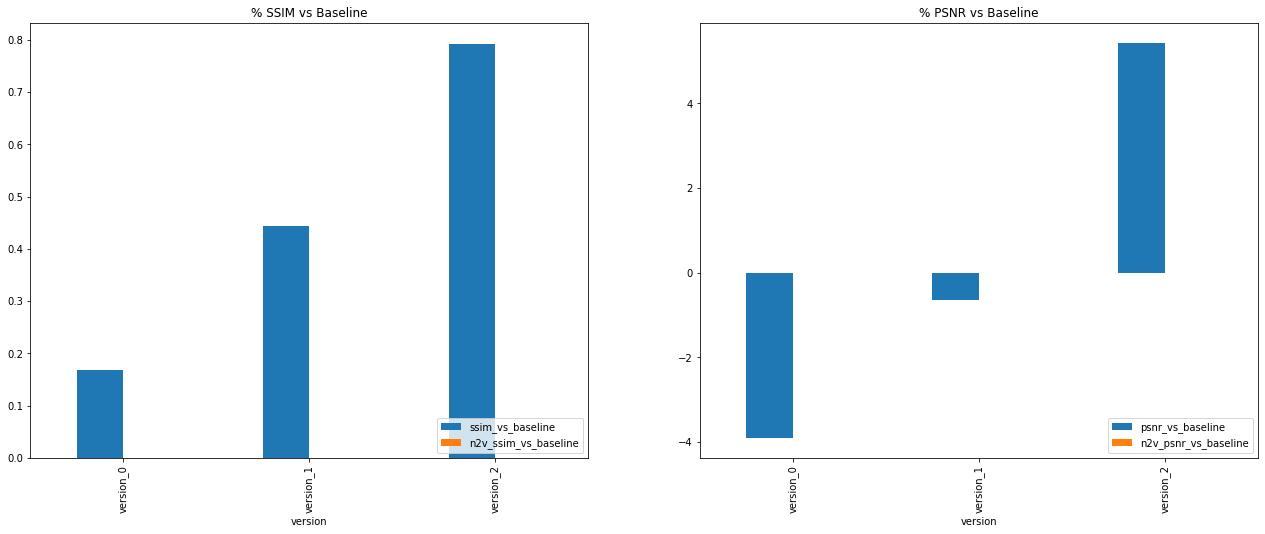

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

## Weighted Bernoulli Fourier Mask comparison

In [5]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo02_dummy/fourierWeightedBernoulliMask_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,fourierWeightedBernoulliMask_comparison,version_0,singleCET_FourierDataset,0,Fourier with weightedBernoulliMask,{'p': '0.5'},18.273876,0.985311,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.253181,0.976708,17.703468,0.978664,0.679184,-0.199851,3.222012,-8.192106
1,fourierWeightedBernoulliMask_comparison,version_1,singleCET_FourierDataset,0,Fourier with weightedBernoulliMask=0.5,{'p': '0.5'},18.370173,0.985493,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.253181,0.976708,17.703468,0.978664,0.697772,-0.199851,3.765952,-8.192106
2,fourierWeightedBernoulliMask_comparison,version_2,singleCET_FourierDataset,0,Fourier no weightedBernoulliMask (OG),{'p': '0.5'},18.632792,0.986354,17.703468,0.978664,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.253181,0.976708,17.703468,0.978664,0.785742,-0.199851,5.249385,-8.192106


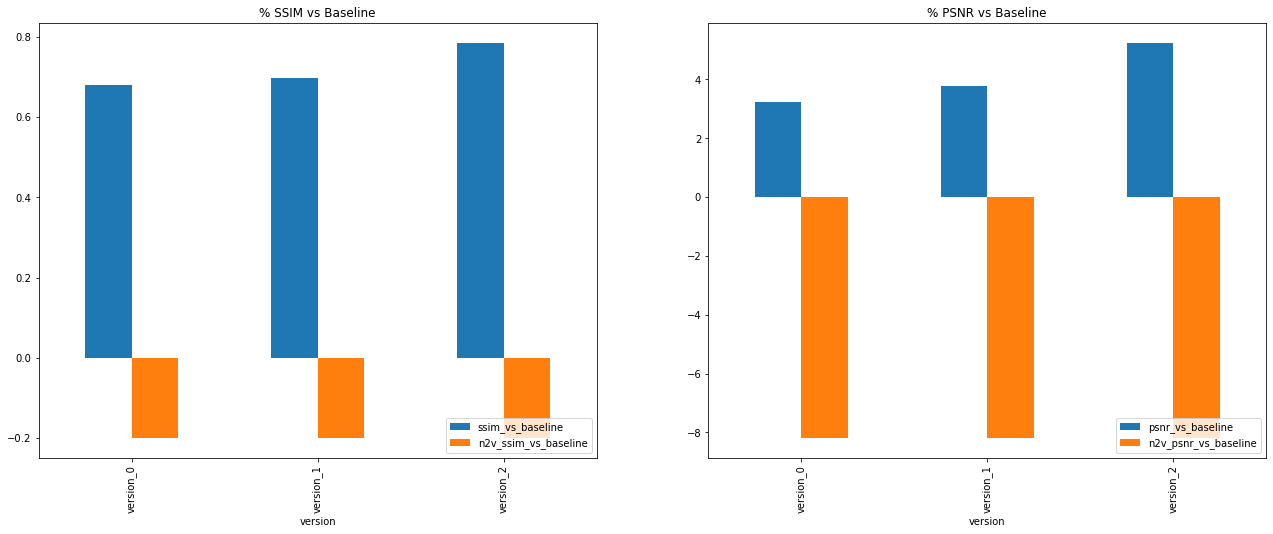

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

# Tomo02 cryoCAREDummy

## normal vs deconvolved

### Gaussian + Poisson

In [28]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo02_cryoCAREDummy_noisyGaussPoiss/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},16.925308,0.971530,17.058134,0.972387,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.922314,0.983201,17.058134,0.972387,-0.088182,1.112085,-0.778666,-0.796221
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},18.348299,0.981076,14.690105,0.967013,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,null,null,false,19.378237,0.988724,17.058134,0.972387,0.893505,1.680071,7.563342,13.601152
8,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},17.759405,0.981372,17.058134,0.972387,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,16.922314,0.983201,17.058134,0.972387,0.923994,1.112085,4.111065,-0.796221
6,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},16.801239,0.975889,14.690105,0.967013,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,null,null,false,19.378237,0.988724,17.058134,0.972387,0.360127,1.680071,-1.505997,13.601152
5,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},14.721915,0.920380,14.690105,0.967013,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,true,true,true,16.922314,0.983201,17.058134,0.972387,-5.348482,1.112085,-13.695629,-0.796221
7,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},14.366082,0.911524,14.690105,0.967013,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,false,true,true,16.922314,0.983201,17.058134,0.972387,-6.259224,1.112085,-15.781632,-0.796221
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},16.860472,0.972572,17.058134,0.972387,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,16.922314,0.983201,17.058134,0.972387,0.018996,1.112085,-1.158757,-0.796221
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},17.783190,0.978375,14.690105,0.967013,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,false,false,true,16.922314,0.983201,17.058134,0.972387,0.615724,1.112085,4.250498,-0.796221
4,normal_vs_deconvolved_comparison,version_8,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},16.874067,0.972580,17.058134,0.972387,tomo02_cryoCAREDummy_noisyGaussPoiss.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,16.922314,0.983201,17.058134,0.972387,0.019774,1.112085,-1.079056,-0.796221


In [29]:
data_log.set_index(['version', 'Version_comment'])[['dataset', 'full_tomo_psnr', 'full_tomo_ssim', 'baseline_psnr_best', 'baseline_ssim_best']]

,,dataset,full_tomo_psnr,full_tomo_ssim,baseline_psnr_best,baseline_ssim_best
version,Version_comment,,,,,
version_0,Deconvolved bernoulli,singleCET_dataset,16.925308,0.971530,17.058134,0.972387
version_1,Bernoull,singleCET_dataset,18.348299,0.981076,17.058134,0.972387
version_2,Deconvolved Fourier,singleCET_FourierDataset,17.759405,0.981372,17.058134,0.972387
version_3,Fourier,singleCET_FourierDataset,16.801239,0.975889,17.058134,0.972387
version_4,Sim N2N denoising using deconv reconstruction as target.,singleCET_ProjectedDataset,14.721915,0.920380,17.058134,0.972387
version_5,Sim N2N denoising using reconstruction as target.,singleCET_ProjectedDataset,14.366082,0.911524,17.058134,0.972387
version_6,Sim N2N denoising using deconv data as target.,singleCET_ProjectedDataset,16.860472,0.972572,17.058134,0.972387
version_7,Sim N2N denoising using raw data as target.,singleCET_ProjectedDataset,17.783190,0.978375,17.058134,0.972387
version_8,Sim N2N denoising using deconvolved data as target.,singleCET_ProjectedDataset,16.874067,0.972580,17.058134,0.972387


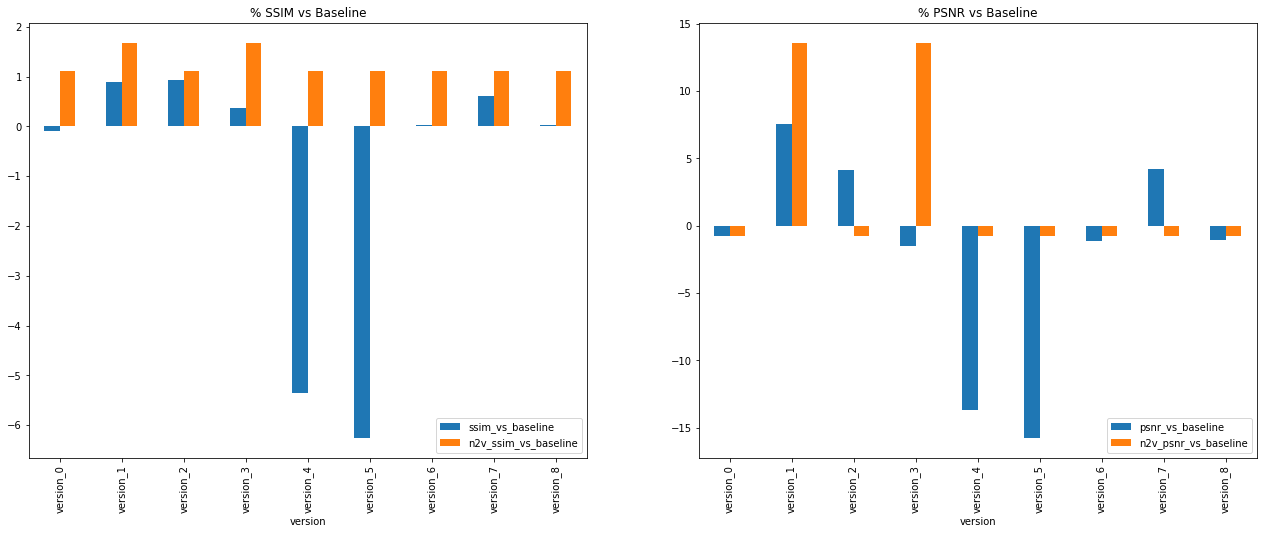

In [4]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

### Gaussian + Poisson + Perlin

In [5]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo02_cryoCAREDummy_noisyGaussPoissPerlin/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},16.691645,0.966008,16.782650,0.966511,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,15.795741,0.950869,16.782650,0.966511,-0.052086,-1.618483,-0.542258,-5.880531
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},17.494829,0.967642,14.572391,0.955833,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,null,null,false,16.147234,0.929234,16.782650,0.966511,0.117019,-3.856871,4.243544,-3.786148
8,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},17.553444,0.977618,16.782650,0.966511,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,null,null,true,15.795741,0.950869,16.782650,0.966511,1.149169,-1.618483,4.592802,-5.880531
6,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},16.553244,0.966544,14.572391,0.955833,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,null,null,false,16.147234,0.929234,16.782650,0.966511,0.003373,-3.856871,-1.366926,-3.786148
5,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv reconstruction ...,{'p': '0.5'},13.440897,0.897441,14.572391,0.955833,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,true,true,true,15.795741,0.950869,16.782650,0.966511,-7.146410,-1.618483,-19.911951,-5.880531
7,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using reconstruction as target.,{'p': '0.5'},12.885587,0.864003,14.572391,0.955833,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,false,true,true,15.795741,0.950869,16.782650,0.966511,-10.606016,-1.618483,-23.220786,-5.880531
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},16.584427,0.966925,16.782650,0.966511,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,15.795741,0.950869,16.782650,0.966511,0.042762,-1.618483,-1.181119,-5.880531
3,normal_vs_deconvolved_comparison,version_7,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},17.150509,0.966436,14.572391,0.955833,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,false,false,true,15.795741,0.950869,16.782650,0.966511,-0.007789,-1.618483,2.191900,-5.880531
4,normal_vs_deconvolved_comparison,version_8,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},16.576660,0.966894,16.782650,0.966511,tomo02_cryoCAREDummy_noisyGaussPoissPerlin.mrc,tomo02_cryoCAREDummy.mrc,true,false,true,15.795741,0.950869,16.782650,0.966511,0.039604,-1.618483,-1.227398,-5.880531


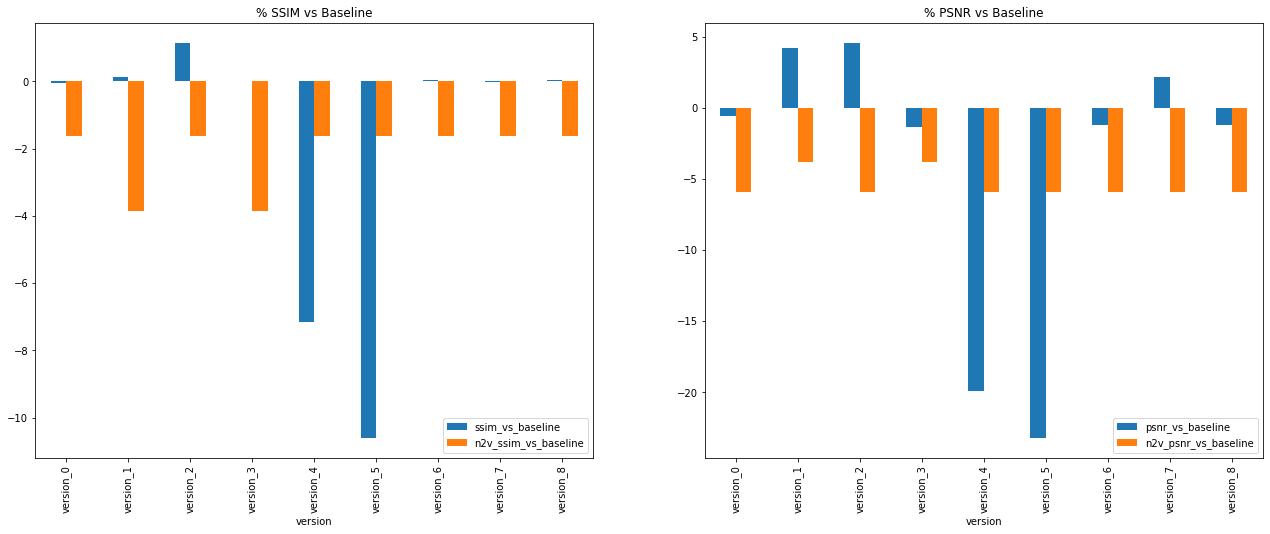

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

# Tomo04 Dummy

**Conclusions about this experiments**

## normal vs deconvolved

In [11]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo04_dummy/normal_vs_deconvolved_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir, ignore_deconv=False)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
1,normal_vs_deconvolved_comparison,version_0,singleCET_dataset,0,Deconvolved bernoulli,{'p': '0.5'},18.316292,0.976679,18.390638,0.976951,tomo04_dummy.mrc,tomo04_cryoCAREDummy.mrc,null,null,true,15.864837,0.967133,18.390638,0.976951,-0.027790,-1.004984,-0.404263,-13.734171
2,normal_vs_deconvolved_comparison,version_1,singleCET_dataset,0,Bernoull,{'p': '0.5'},16.583258,0.958339,14.709962,0.956136,tomo04_dummy.mrc,tomo04_cryoCAREDummy.mrc,null,null,false,NaN,NaN,18.390638,0.976951,-1.905089,NaN,-9.827721,NaN
6,normal_vs_deconvolved_comparison,version_2,singleCET_FourierDataset,0,Deconvolved Fourier,{'p': '0.5'},19.551924,0.984713,18.390638,0.976951,tomo04_dummy.mrc,tomo04_cryoCAREDummy.mrc,null,null,true,15.864837,0.967133,18.390638,0.976951,0.794539,-1.004984,6.314546,-13.734171
4,normal_vs_deconvolved_comparison,version_3,singleCET_FourierDataset,0,Fourier,{'p': '0.5'},16.196423,0.961255,14.709962,0.956136,tomo04_dummy.mrc,tomo04_cryoCAREDummy.mrc,null,null,false,NaN,NaN,18.390638,0.976951,-1.606588,NaN,-11.931156,NaN
3,normal_vs_deconvolved_comparison,version_4,singleCET_ProjectedDataset,0,Sim N2N denoising using deconv data as target.,{'p': '0.5'},18.122597,0.976686,18.390638,0.976951,tomo04_dummy.mrc,tomo04_cryoCAREDummy.mrc,true,false,true,15.864837,0.967133,18.390638,0.976951,-0.027083,-1.004984,-1.457489,-13.734171
5,normal_vs_deconvolved_comparison,version_5,singleCET_ProjectedDataset,0,Sim N2N denoising using raw data as target.,{'p': '0.5'},17.199615,0.965423,14.709962,0.956136,tomo04_dummy.mrc,tomo04_cryoCAREDummy.mrc,false,false,true,15.864837,0.967133,18.390638,0.976951,-1.180024,-1.004984,-6.476245,-13.734171
0,normal_vs_deconvolved_comparison,version_6,singleCET_ProjectedDataset,0,Sim N2N denoising using deconvolved data as ta...,{'p': '0.5'},18.140146,0.976694,18.390638,0.976951,tomo04_dummy.mrc,tomo04_cryoCAREDummy.mrc,true,false,true,15.864837,0.967133,18.390638,0.976951,-0.026345,-1.004984,-1.362063,-13.734171


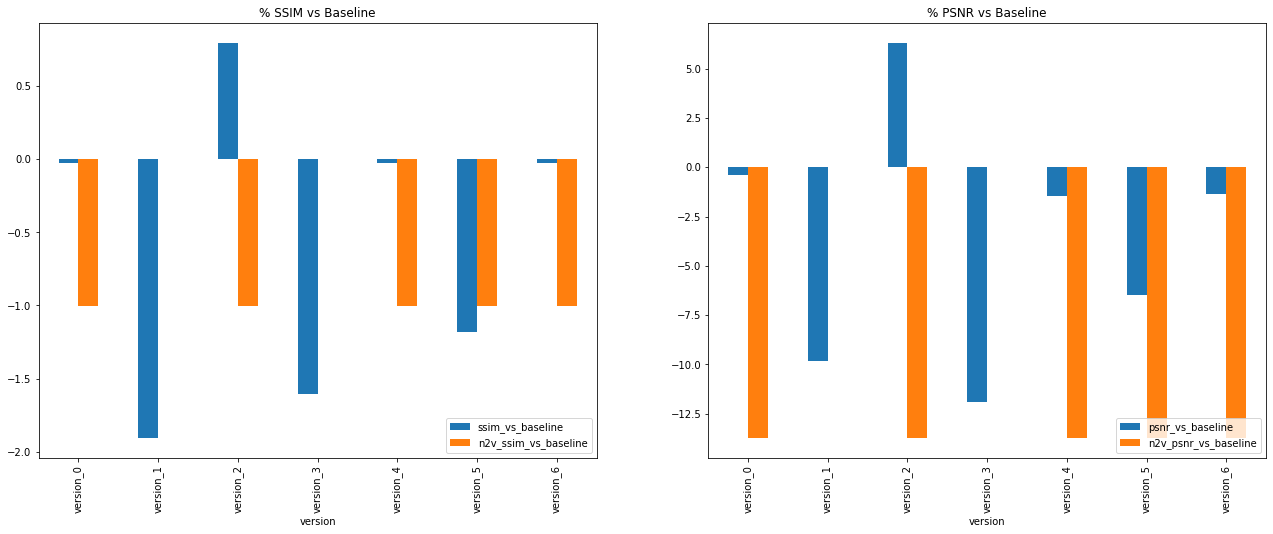

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')